### Libraries

In [167]:
import pdb
import pandas as pd
import numpy as np
import os
import random
from scipy import stats
from scipy.stats import gaussian_kde
from datetime import datetime, timedelta
from faker import Faker
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import seaborn as sns 
from sklearn.model_selection import train_test_split
np.random.seed(3101)
random_state = np.random.RandomState(3101)
fake = Faker()
pd.set_option('display.float_format', lambda x: '{:.6f}'.format(x))

### Data Import

In [168]:
bank_df_train = pd.read_csv('./data/main/train.csv')
n_train = bank_df_train.shape[0]

### Data Cleaning

#### Remove Irrelevant Columns 

In [169]:
bank_df_train = bank_df_train.drop(["id", "CustomerId", "Surname", "CreditScore", "Geography", "HasCrCard"],axis = 1)

### Adding new columns 

#### Customer Id 

In [170]:
cust_id = np.arange(1,n_train+1,1)
bank_df_train['CustomerId'] = cust_id


#### Balance

Removed those with 0 balance and used Normal dist from the remaining 
Then, added some noise/outliers 

In [171]:
zero_count = (bank_df_train['Balance'] == 0).sum()
total_count = len(bank_df_train)
zero_percentage = (zero_count / total_count) * 100

print(f"Percentage of 0 entries in 'Balance': {zero_percentage:.2f}%")

non_zero_data = bank_df_train.loc[bank_df_train['Balance'] != 0, 'Balance']
mean_non_zero = non_zero_data.mean()
std_non_zero = non_zero_data.std()

zero_indices = bank_df_train.index[bank_df_train['Balance'] == 0]
num_zeros = len(zero_indices)
random_samples = np.random.normal(loc=mean_non_zero, scale=std_non_zero, size=num_zeros)
bank_df_train.loc[zero_indices, 'Balance'] = random_samples

print(bank_df_train['Balance'].describe())

Percentage of 0 entries in 'Balance': 54.32%
count   165034.000000
mean    121351.823171
std      24958.566254
min         18.330000
25%     104784.230000
50%     121798.530000
75%     137853.000000
max     250898.090000
Name: Balance, dtype: float64


In [172]:
bank_df_train['Balance'] = round(bank_df_train['Balance'],2)

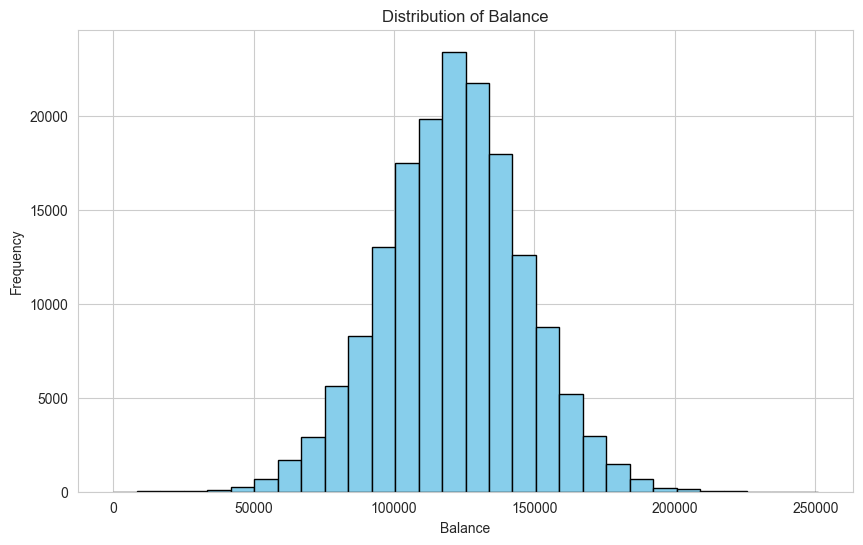

In [173]:
plt.figure(figsize=(10, 6))
plt.hist(bank_df_train['Balance'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.title('Distribution of Balance')
plt.grid(True)
plt.show()

#### Age 

Convert to int type 

In [174]:
bank_df_train['Age'] = bank_df_train['Age'].astype(int)

#### Tenure 

Scaled from Original Dataset to fit into 19 months 
Then, skew some to 18/19 mths to fit GXS context 

In [175]:
aug_2022 = datetime(2022, 8, 31) #when GXS opened 
today = datetime.now()
months_since_aug_2022 = (today.year - aug_2022.year) * 12 + today.month - aug_2022.month - 2
def scale_int_to_months(int_val):
    return int_val * (months_since_aug_2022 / 10)
bank_df_train['Tenure'] = bank_df_train['Tenure'] * (months_since_aug_2022 / 10)
bank_df_train['Tenure'] = bank_df_train['Tenure'].astype(int)

random_numbers = np.random.rand(n_train)
threshold = 0.5
print(random_numbers)
bank_df_train.loc[random_numbers > threshold, 'Tenure'] += 1

print(bank_df_train['Tenure'].describe())

[0.63461568 0.31213008 0.56974709 ... 0.18298272 0.75245866 0.8570277 ]
count   165034.000000
mean         9.123199
std          5.161177
min          0.000000
25%          5.000000
50%          9.000000
75%         13.000000
max         19.000000
Name: Tenure, dtype: float64


In [176]:
bank_df_train['Tenure'].value_counts()

Tenure
10    16424
1     10887
3      9025
4      9020
12     8906
13     8904
14     8863
8      8803
7      8751
9      8687
15     8657
17     8398
6      8335
16     8311
2      8297
5      8295
11     7979
19     2979
18     2930
0      2583
Name: count, dtype: int64

#### Churn Date

In [177]:
start_date = datetime(2022, 8, 31)
end_date = end_date = datetime.now().strftime('%Y-%m-%d') 

def generate_random_date(exited, tenure_months):
    if exited == 1:
        tenure_days = tenure_months * 30
        random_date = np.random.choice(pd.date_range(start=start_date + timedelta(days=tenure_days), end=end_date, freq='D'))
        return random_date
    else:
        return np.nan
bank_df_train['ChurnDate'] = bank_df_train.apply(lambda row: generate_random_date(row['Exited'], row['Tenure']), axis=1)

print(bank_df_train[['Tenure', 'ChurnDate']].describe())

             Tenure                      ChurnDate
count 165034.000000                          34921
mean       9.123199  2023-11-05 08:19:29.451046400
min        0.000000            2022-09-02 00:00:00
25%        5.000000            2023-08-15 00:00:00
50%        9.000000            2023-12-07 00:00:00
75%       13.000000            2024-02-20 00:00:00
max       19.000000            2024-04-15 00:00:00
std        5.161177                            NaN


#### Months Inactive

In [178]:
np.random.seed(3101)
bank_df_train['MonthsInactive'] = np.minimum(np.random.normal(0.5, 1.5, n_train), bank_df_train['Tenure'] * 12)
bank_df_train['MonthsInactive'] = np.maximum(bank_df_train['MonthsInactive'], 0)

def set_max_to_tenure(row):
    return min(row['MonthsInactive'], row['Tenure'])

bank_df_train['MonthsInactive'] = np.maximum(bank_df_train['MonthsInactive'], 0)
bank_df_train['MonthsInactive'] = bank_df_train.apply(set_max_to_tenure, axis=1)
bank_df_train['MonthsInactive'] = bank_df_train['MonthsInactive'].astype(int)

bank_df_train.loc[bank_df_train['Exited'] == 1, 'MonthsInactive'] = np.nan

print(bank_df_train[['Tenure', 'ChurnDate', 'MonthsInactive']].head(20))

    Tenure  ChurnDate  MonthsInactive
0        6        NaT        1.000000
1        1        NaT        0.000000
2       19        NaT        2.000000
3        3        NaT        0.000000
4        9        NaT        0.000000
5        8 2024-01-22             NaN
6       14        NaT        2.000000
7        1        NaT        1.000000
8        7        NaT        1.000000
9        7        NaT        0.000000
10      11        NaT        0.000000
11       5        NaT        0.000000
12      17        NaT        0.000000
13       9        NaT        1.000000
14      12        NaT        0.000000
15       9        NaT        1.000000
16      12        NaT        2.000000
17       8        NaT        0.000000
18      15 2024-01-29             NaN
19       1 2022-11-12             NaN


#### Transaction Freq & Amt 

   TransactionFreq  TransactionAmt
0                9      145.718221
1               34      162.527690
2               48      189.837106
3               18      194.532102
4                2      144.361474
5               44      161.830082
6                9      164.521048
7               10      162.416440
8               32      137.160083
9                7      179.038593
   TransactionFreq  TransactionAmt
0                0        0.000000
1               34     6487.460000
2                0        0.000000
3               18     3859.440000
4                2     1135.480000
5                0        0.000000
6                0        0.000000
7                0        0.000000
8                0        0.000000
9                7     2320.550000
<bound method NDFrame.describe of         Gender  Age  Tenure       Balance  NumOfProducts  IsActiveMember  \
0         Male   33       6 133877.390000              2        0.000000   
1         Male   33       1 124654.360000   

C:\Users\2002s\AppData\Local\Temp\ipykernel_24264\2984492598.py:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  trans_df['Date'] = pd.to_datetime(trans_df['Date'], errors='coerce')


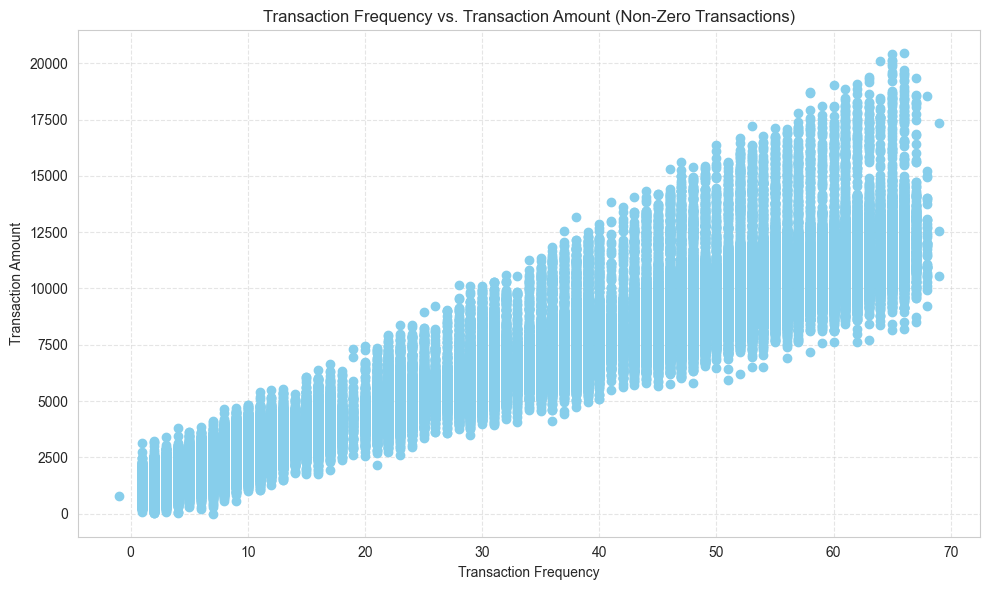

In [179]:
trans_df = pd.read_csv('./data/Daily Household Transactions.csv')

trans_df['Date'] = pd.to_datetime(trans_df['Date'], errors='coerce')

trans_df = trans_df.dropna(subset=['Date'])

trans_df['Date'] = trans_df['Date'].dt.strftime('%Y-%m-%d')

trans_df['Year'] = trans_df['Date'].str[:4].astype(int)
trans_df['Month'] = trans_df['Date'].str[5:7].astype(int)
trans_df['Day'] = trans_df['Date'].str[8:10].astype(int)

exchange_rate_inr_to_sgd = 0.016
trans_df['Amount'] = trans_df['Amount'] * exchange_rate_inr_to_sgd
trans_df['Amount'] = trans_df['Amount'].round(2)

monthly_data = trans_df.groupby(['Year', 'Month']).agg({'Amount': 'sum', 'Date': 'count'}).reset_index()
monthly_data.rename(columns={'Amount': 'TotalAmount', 'Date': 'Frequency'}, inplace=True)
monthly_data['AvgTransactionPerMonth'] = monthly_data['TotalAmount'] / monthly_data['Frequency']


kde_freq = KernelDensity(bandwidth=1, kernel='gaussian')
kde_amount = KernelDensity(bandwidth=25, kernel='gaussian')

kde_freq.fit(monthly_data['Frequency'].values.reshape(-1, 1))
kde_amount.fit(monthly_data['AvgTransactionPerMonth'].values.reshape(-1, 1))

new_freq_samples = kde_freq.sample(len(bank_df_train)).reshape(-1)
new_amount_samples = kde_amount.sample(len(bank_df_train)).reshape(-1)

bank_df_train['TransactionFreq'] = new_freq_samples
bank_df_train['TransactionFreq'] = bank_df_train['TransactionFreq'].astype(int)
bank_df_train['TransactionAmt'] = new_amount_samples
percentile_75 = bank_df_train['TransactionAmt'].quantile(0.75)

min_value = bank_df_train['TransactionAmt'].min()
max_value = bank_df_train['TransactionAmt'].max()
bank_df_train['TransactionAmt'] = ((bank_df_train['TransactionAmt'] - min_value) / (max_value - min_value)) * (percentile_75 - min_value) + percentile_75
print(bank_df_train[['TransactionFreq', 'TransactionAmt']].head(10))


bank_df_train['TransactionAmt'] = bank_df_train['TransactionAmt'] * bank_df_train['TransactionFreq']


bank_df_train.loc[(bank_df_train['Exited'] == 1) | (bank_df_train['MonthsInactive'] > 0), ['TransactionFreq', 'TransactionAmt']] = 0

non_zero_mask = (bank_df_train['TransactionFreq'] != 0) & (bank_df_train['TransactionAmt'] != 0)
noise_freq = np.random.normal(0, 0.00, len(bank_df_train))
noise_amt = np.random.normal(1000, 500, len(bank_df_train))

bank_df_train.loc[non_zero_mask, 'TransactionFreq'] += noise_freq[non_zero_mask]
bank_df_train.loc[non_zero_mask, 'TransactionAmt'] += noise_amt[non_zero_mask]

bank_df_train['TransactionAmt'] = bank_df_train['TransactionAmt'].abs().round(2)

print(bank_df_train[['TransactionFreq', 'TransactionAmt']].head(10))
print(bank_df_train.describe)



non_zero_rows = bank_df_train[bank_df_train['TransactionAmt'] != 0] 
plt.figure(figsize=(10, 6))
plt.scatter(non_zero_rows['TransactionFreq'], non_zero_rows['TransactionAmt'], color='skyblue')
plt.title('Transaction Frequency vs. Transaction Amount (Non-Zero Transactions)')
plt.xlabel('Transaction Frequency')
plt.ylabel('Transaction Amount')
plt.grid(axis='both', linestyle='--', alpha=0.5)  
plt.tight_layout()
plt.show()

#### Service Support Freq (per mth)

Includes missed calls 

In [180]:
support_freq = pd.read_csv("./data/support_frequency.csv")
kde = gaussian_kde(support_freq['no_of_cases'])
bank_df_train['ServiceSupportFrequency'] = abs(kde.resample(n_train).flatten()/12).astype(int)

print(bank_df_train['ServiceSupportFrequency'].describe())


count   165034.000000
mean        13.376116
std         12.519440
min          0.000000
25%          4.000000
50%          9.000000
75%         20.000000
max         69.000000
Name: ServiceSupportFrequency, dtype: float64


#### Net Promoter Score (NPS)
Measure of customer satisfaction and loyalty.
Scaled from 1 to 10 


In [181]:
nps = pd.read_csv('./data/NPS.csv')

nps_data = nps.groupby('Customer Name').agg({'NPS':'mean'}).reset_index()
kde = gaussian_kde(nps_data['NPS'])
bank_df_train['NPS'] = abs(kde.resample(n_train).flatten()).astype(int)
bank_df_train['NPS'] = np.ceil(bank_df_train['NPS']/12*10)

print(bank_df_train['NPS'].describe())

count   165034.000000
mean         5.739823
std          2.985945
min          0.000000
25%          4.000000
50%          7.000000
75%          8.000000
max         10.000000
Name: NPS, dtype: float64


#### Education
Education level might influence financial behavior and churn.


In [182]:
education_marital = pd.read_csv("./data/education_marital.csv")
education = education_marital['Education_Level'].unique()
edu, counts = np.unique(education, return_counts=True)
value_to_index = {value: i for i, value in enumerate(edu)}
numerical_data = [value_to_index[value] for value in education]
kde = gaussian_kde(numerical_data)
x_values = np.unique(numerical_data)
pdf_values = kde(x_values)
pmf = pdf_values / np.sum(pdf_values)
resampled_indices = np.random.choice(x_values, size=n_train, p=pmf)
resampled_values = [edu[index] for index in resampled_indices]

bank_df_train['Education'] = resampled_values
bank_df_train['Education'].replace({'Unknown': 'PSLE'}, inplace=True)
bank_df_train['Education'].replace({'Uneducated': np.random.choice(['A', 'Diploma'])}, inplace=True)
bank_df_train['Education'].replace({'High School': 'Bachelors'}, inplace=True)
bank_df_train['Education'].replace({'College': 'O/N'}, inplace=True)
bank_df_train['Education'].replace({'Graduate': 'Masters'}, inplace=True)
bank_df_train['Education'].replace({'Post-Graduate': 'PHD'}, inplace=True)
bank_df_train['Education'].replace({'Doctorate': 'Post-Doc'}, inplace=True)

print(bank_df_train['Education'].unique())

['Masters' 'Post-Doc' 'O/N' 'Bachelors' 'PHD' 'PSLE' 'Diploma']


In [183]:
bank_df_train['Education'].value_counts()

Education
Bachelors    27609
PHD          26771
Masters      26666
Diploma      24245
Post-Doc     24097
O/N          17946
PSLE         17700
Name: count, dtype: int64

#### Employment Status
Indicates financial stability, affecting churn likelihood

In [184]:
employment = pd.read_csv("./data/employment.csv")

employment_data = employment['job'].unique()

employment_status, counts = np.unique(employment_data, return_counts=True)
value_to_index = {value: i for i, value in enumerate(employment_status)}
numerical_data = [value_to_index[value] for value in employment_data]

kde = gaussian_kde(numerical_data)

x_values = np.unique(numerical_data)
pdf_values = kde(x_values)
pmf = pdf_values / np.sum(pdf_values)

resampled_indices = np.random.choice(x_values, size=n_train, p=pmf)

resampled_values = [employment_status[index] for index in resampled_indices]

bank_df_train['EmploymentStatus'] = resampled_values

bank_df_train['EmploymentStatus'].replace({'admin.': 'Fulltime'}, inplace=True)
bank_df_train['EmploymentStatus'].replace({'blue-collar': 'Fulltime'}, inplace=True)
bank_df_train['EmploymentStatus'].replace({'entrepreneur': 'Fulltime'}, inplace=True)
bank_df_train['EmploymentStatus'].replace({'housemaid': 'Parttime'}, inplace=True)
bank_df_train['EmploymentStatus'].replace({'management': 'Fulltime'}, inplace=True)
bank_df_train['EmploymentStatus'].replace({'retired': 'Retired'}, inplace=True)
bank_df_train['EmploymentStatus'].replace({'student': 'Student'}, inplace=True)
bank_df_train['EmploymentStatus'].replace({'services': 'Fulltime'}, inplace=True)
bank_df_train['EmploymentStatus'].replace({'self-employed': 'Self-employed'}, inplace=True)
bank_df_train['EmploymentStatus'].replace({'technician': 'Parttime'}, inplace=True)
bank_df_train['EmploymentStatus'].replace({'unemployed': 'Unemployed'}, inplace=True)
bank_df_train['EmploymentStatus'].replace({'unknown': 'Parttime'}, inplace=True)

print(bank_df_train['EmploymentStatus'].unique())

['Fulltime' 'Parttime' 'Unemployed' 'Student' 'Self-employed' 'Retired']


In [185]:
bank_df_train['EmploymentStatus'].value_counts()

EmploymentStatus
Fulltime         67155
Parttime         38731
Retired          15908
Self-employed    15900
Student          15337
Unemployed       12003
Name: count, dtype: int64

#### Marital Status
Can impact financial decision-making and churn behavior. 

With reference to current SG context 

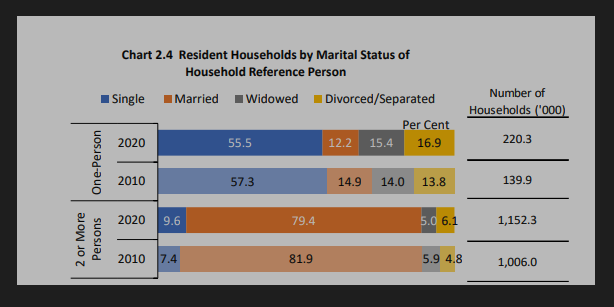

In [186]:
percentage_single = (55.5 * 220.3 + 9.6 * 1152.3) / (220.3 + 1152.3)
percentage_married = (12.2 * 220.3 + 79.4 * 1152.3) / (220.3 + 1152.3)
percentage_widowed = (15.4 * 220.3 + 5 * 1152.3) / (220.3 + 1152.3) #25 above
percentage_divorced = (16.9 * 220.3 + 6.1 * 1152.3) / (220.3 + 1152.3) #25 above

marital_status = ['Single', 'Married', 'Widowed', 'Divorced']
total_percentage = percentage_single + percentage_married + percentage_widowed + percentage_divorced
normalized_percentages = [percentage_single / total_percentage,
                           percentage_married / total_percentage,
                           percentage_widowed / total_percentage,
                           percentage_divorced / total_percentage]

bank_df_train['MaritalStatus'] = np.random.choice(['Single', 'Married', 'Widowed', 'Divorced'],
                                                   size=len(bank_df_train), p=normalized_percentages)


young_divorced_widowed_indices = bank_df_train[(bank_df_train['Age'] < 25) & (bank_df_train['MaritalStatus'].isin(['Widowed', 'Divorced']))].index
bank_df_train.loc[young_divorced_widowed_indices, 'MaritalStatus'] = 'Single'

print(bank_df_train['MaritalStatus'].unique())

['Married' 'Single' 'Divorced' 'Widowed']


In [187]:
bank_df_train['MaritalStatus'].value_counts()

MaritalStatus
Married     112885
Single       28719
Divorced     12593
Widowed      10837
Name: count, dtype: int64

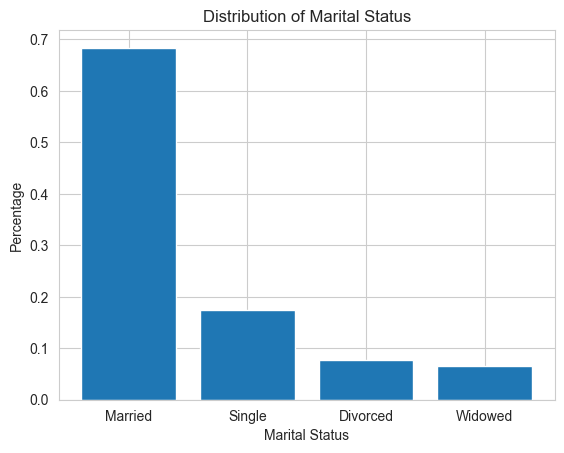

In [188]:
marital_status_distribution = bank_df_train['MaritalStatus'].value_counts(normalize=True)
plt.bar(marital_status_distribution.index, marital_status_distribution.values)
plt.xlabel('Marital Status')
plt.ylabel('Percentage')
plt.title('Distribution of Marital Status')
plt.show()

#### Housing Status
Reflects stability and long-term commitment, influencing churn. 

In [189]:
housing = pd.read_csv("./data/housing.csv")

housing_status = housing['House_Ownership'].unique()

house, counts = np.unique(housing_status, return_counts=True)
value_to_index = {value: i for i, value in enumerate(house)}
numerical_data = [value_to_index[value] for value in housing_status]

kde = gaussian_kde(numerical_data)

x_values = np.unique(numerical_data)
pdf_values = kde(x_values)

pmf = pdf_values / np.sum(pdf_values)

resampled_indices = np.random.choice(x_values, size=n_train, p=pmf)

resampled_values = [house[index] for index in resampled_indices]

bank_df_train['HousingStatus'] = resampled_values

print(bank_df_train['HousingStatus'].unique())

['rented' 'owned' 'norent_noown']


In [190]:
bank_df_train['HousingStatus'].value_counts()

HousingStatus
owned           64351
norent_noown    50381
rented          50302
Name: count, dtype: int64

#### Number of Dependents
Impacts financial priorities and risk tolerance, affecting churn.

In [191]:
dependants_df = pd.read_csv('./data/education+dependents+maritalstatus/BankChurners.csv')

kde = gaussian_kde(dependants_df['Dependent_count'])

bank_df_train['Dependants'] = np.maximum(kde.resample(len(bank_df_train)).flatten(), 0)
bank_df_train['Dependants'] = np.round(bank_df_train['Dependants']).astype(int)

print(bank_df_train['Dependants'].value_counts())
print(bank_df_train['Dependants'].unique())

Dependants
3    44401
2    43156
1    29856
4    25577
0    14968
5     7021
6       55
Name: count, dtype: int64
[2 1 4 3 0 5 6]


#### Marketing Offers Accepted (per Mth)
Indicates responsiveness to incentives, affecting churn. Range 0-1, (percentage of marketing offers they accept, e.g.5 offer, 4 accepted, the value of the column 0.8)

In [192]:
marketing_df = pd.read_csv('./data/marketing offers/marketing_campaign.csv', sep=';')

marketing_df["MarketingOffersAcceptance"] = (marketing_df['AcceptedCmp1'] + marketing_df['AcceptedCmp2'] + marketing_df['AcceptedCmp3'] + marketing_df['AcceptedCmp4'] + marketing_df['AcceptedCmp5']) / 5

kde = gaussian_kde(marketing_df['MarketingOffersAcceptance'])

bank_df_train['MarketingOffersAcceptance'] = np.maximum(kde.resample(len(bank_df_train)).flatten(), 0)

print(bank_df_train['MarketingOffersAcceptance'].describe())

count   165034.000000
mean         0.068574
std          0.133226
min          0.000000
25%          0.000000
50%          0.009716
75%          0.046240
max          0.893740
Name: MarketingOffersAcceptance, dtype: float64


#### Preferred Payment Methods 
Reflects preferred banking channels and engagement level. 
faker

With reference to current sg context 

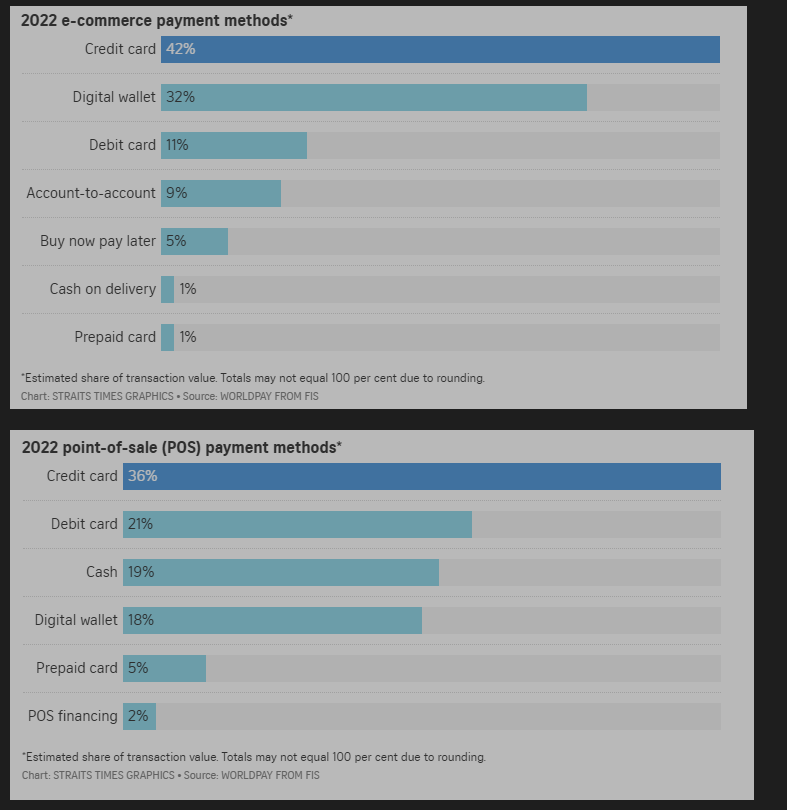

In [193]:
Debit = 11 + 21
Paynow = 32 + 18
FAST = 9
Cash = 1

Payment_methods = ['Debit', 'Paynow', 'FAST', 'Cash']
total = Debit + Paynow + FAST + Cash
percentages = [Debit / total, Paynow / total, FAST / total, Cash / total]

print(percentages)

bank_df_train['PaymentMethod'] = np.random.choice(Payment_methods,
                                                   size=len(bank_df_train), p=percentages)

bank_df_train['PaymentMethod'].unique()
bank_df_train['PaymentMethod'].value_counts()

[0.34782608695652173, 0.5434782608695652, 0.09782608695652174, 0.010869565217391304]


PaymentMethod
Paynow    89666
Debit     57519
FAST      16038
Cash       1811
Name: count, dtype: int64

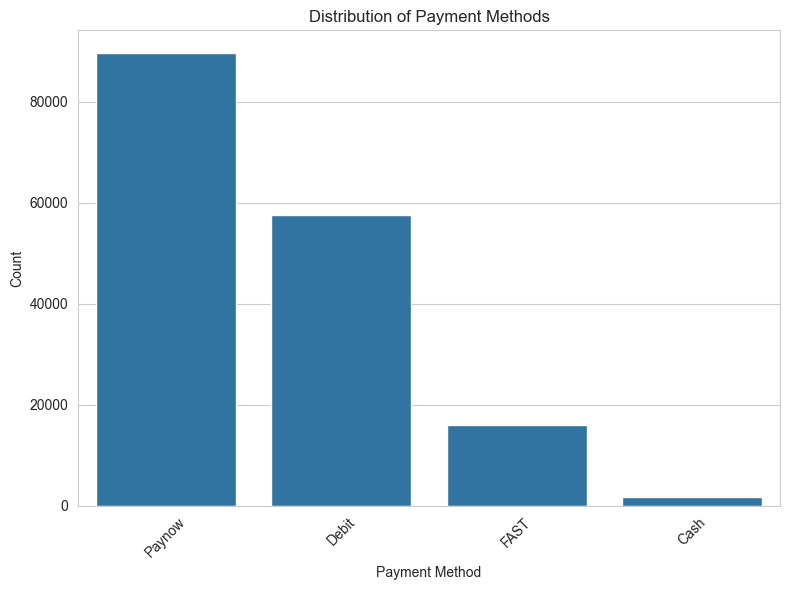

In [194]:
payment_counts = bank_df_train['PaymentMethod'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=payment_counts.index, y=payment_counts.values)
plt.xlabel('Payment Method')
plt.ylabel('Count')
plt.title('Distribution of Payment Methods')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()


#### Brand Satisfaction
Provides direct feedback on satisfaction levels, predicting churn. 

In [195]:
cust_satisfaction_df = pd.read_csv('./data/satisfaction score/Customer-Churn-Records.csv')

kde = gaussian_kde(cust_satisfaction_df['Satisfaction Score'])

fake_data = np.maximum(kde.resample(len(bank_df_train)).flatten(), 0)
fake_data = np.minimum(fake_data.flatten(), 5)
fake_data = np.round(fake_data).astype(int)

bank_df_train['BrandSatisfaction'] = fake_data

print(bank_df_train['BrandSatisfaction'].describe())

count   165034.000000
mean         3.008889
std          1.410416
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: BrandSatisfaction, dtype: float64


In [196]:
bank_df_train['BrandSatisfaction'].value_counts()

BrandSatisfaction
3    33639
2    33291
4    33126
5    32996
1    31586
0      396
Name: count, dtype: int64

#### Feature Satisfaction
Scale on 1 to 5


In [197]:
feature_df = pd.read_csv('./data/feature_and_support_satisfaction/Customer-survey-data.csv')
feature_df = feature_df.dropna()
kde = gaussian_kde(feature_df['How satisfied were you with your overall delivery experience at Ali?                    1-5 where 1 = extremely dissatisfied and 5 = extremely satisfied'])
bank_df_train['FeatureSatisfaction'] = kde.resample(len(bank_df_train)).flatten().astype(int)
bank_df_train['FeatureSatisfaction'] = bank_df_train['FeatureSatisfaction']
bank_df_train['FeatureSatisfaction'] = bank_df_train['FeatureSatisfaction'].astype(int)

rows_to_replace = bank_df_train['FeatureSatisfaction'] == 6
bank_df_train.loc[rows_to_replace, 'FeatureSatisfaction'] = 5


print(bank_df_train['FeatureSatisfaction'].unique())
print(bank_df_train['FeatureSatisfaction'].describe())
print(bank_df_train['FeatureSatisfaction'].value_counts())

[5 0 1 3 4 2]
count   165034.000000
mean         2.816517
std          1.508742
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: FeatureSatisfaction, dtype: float64
FeatureSatisfaction
4    36814
2    35043
3    28921
1    27056
5    26732
0    10468
Name: count, dtype: int64


#### Support Satisfaction
Scale on 1 to 5


In [198]:
feature_df = pd.read_csv('./data/feature_and_support_satisfaction/Customer-survey-data.csv')
feature_df = feature_df.dropna()
kde = gaussian_kde(feature_df['How satisfied were you with the speed of delivery at Alis?                                1-5 where 1 = extremely dissatisfied and 5 = extremely satisfied'])
bank_df_train['SupportSatisfaction'] = kde.resample(len(bank_df_train)).flatten().astype(int)

rows_to_replace = bank_df_train['SupportSatisfaction'] == 6
bank_df_train.loc[rows_to_replace, 'SupportSatisfaction'] = 5

print(bank_df_train['SupportSatisfaction'].unique())
print(bank_df_train['SupportSatisfaction'].describe())
bank_df_train['SupportSatisfaction'].value_counts()

[2 3 5 4 0 1]
count   165034.000000
mean         2.818674
std          1.492741
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: SupportSatisfaction, dtype: float64


SupportSatisfaction
4    37488
2    35188
3    30042
1    26408
5    25663
0    10245
Name: count, dtype: int64

#### Feature Support Frequency (per mth)

In [199]:
support_freq = pd.read_csv("./data/support_frequency.csv")

kde = gaussian_kde(support_freq['no_of_cases'])
bank_df_train['FeatureSupportFrequency'] = abs(kde.resample(n_train).flatten()/12).astype(int)
bank_df_train['FeatureSupportFrequency'] = (bank_df_train['FeatureSupportFrequency'] *0.75).astype(int)
bank_df_train['FeatureSupportFrequency'].describe()

count   165034.000000
mean         9.689500
std          9.388838
min          0.000000
25%          3.000000
50%          6.000000
75%         15.000000
max         51.000000
Name: FeatureSupportFrequency, dtype: float64

#### Loan Amt 

In [200]:
relationship_count = pd.read_csv('./data/loan/credit_train.csv')
relationship_count['Current Loan Amount'].fillna(0, inplace=True) 
relationship_count = relationship_count[relationship_count['Current Loan Amount'] <= 200000]

if np.any(np.isinf(relationship_count['Current Loan Amount'])):
    # Handle infinite values, such as replacing them with a large finite value
    relationship_count['Current Loan Amount'].replace([np.inf, -np.inf], np.finfo(np.float64).max, inplace=True)


median_loan_amount = relationship_count['Current Loan Amount'].median()
below_median = relationship_count[relationship_count['Current Loan Amount'] < median_loan_amount]
above_median = relationship_count[relationship_count['Current Loan Amount'] >= median_loan_amount]

kde_upper = gaussian_kde(above_median['Current Loan Amount'])
kde_lower = gaussian_kde(below_median['Current Loan Amount'])

bank_df_train['LoanAmt'] = np.where(bank_df_train['BrandSatisfaction'] >= 4, abs(kde_upper.resample(n_train).flatten()/12).astype(int) , abs(kde_lower.resample(n_train).flatten()/12).astype(int))

min_value = bank_df_train['LoanAmt'].min()
max_value = bank_df_train['LoanAmt'].max()

new_min_value = 3000
new_max_value = 30000

def scale_values(value):
    scaled_value = new_min_value + ((value - min_value) / (max_value - min_value)) * (new_max_value - new_min_value)
    return scaled_value


bank_df_train['LoanAmt'] = bank_df_train['LoanAmt'].apply(scale_values)

bank_df_train['LoanAmt'] = bank_df_train['LoanAmt'].round(2)

Some ppl might not have loans... so change some to 0

In [201]:
no_loan_idx = np.random.choice(n_train, round(n_train*0.6), replace=False)
bank_df_train.loc[no_loan_idx, 'LoanAmt'] = 0


In [202]:
bank_df_train['LoanAmt'].describe()

count   165034.000000
mean      7059.908732
std       9500.732235
min          0.000000
25%          0.000000
50%          0.000000
75%      15968.070000
max      29932.260000
Name: LoanAmt, dtype: float64

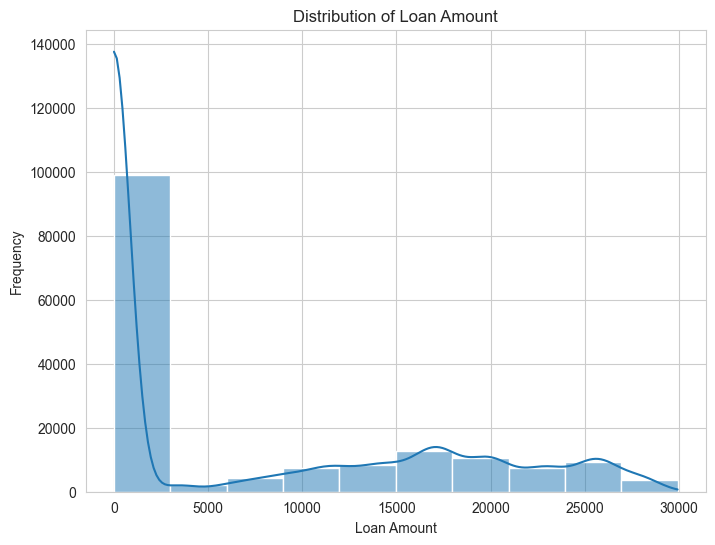

In [203]:
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
sns.histplot(bank_df_train['LoanAmt'], kde=True, bins=10)  # Adjust the number of bins as needed
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Loan Amount')
plt.show()

#### Source of Income 

In [204]:
def choose_value(row):
    if row['EmploymentStatus'] == 'Fulltime':
        return np.random.choice(['Employment', 'Investment'])
    elif row['EmploymentStatus'] == 'Parttime':
        return 'Employment' 
    elif row['EmploymentStatus'] == 'Retired':
        return np.random.choice(['Retirement', 'Rental', 'Investment'])
    elif row['EmploymentStatus'] == 'Student':
        return np.random.choice(['Allowance', 'Employment'])
    elif row['EmploymentStatus'] == 'Self-employed':
        return 'Self-employment'
    elif row['EmploymentStatus'] == 'Unemployed':
        return np.random.choice(['Rental', 'Investment', 'Allowance'])
    
bank_df_train['IncomeSource'] = bank_df_train.apply(choose_value, axis=1)
bank_df_train['IncomeSource'].value_counts()

IncomeSource
Employment         80041
Investment         42886
Self-employment    15900
Allowance          11583
Rental              9357
Retirement          5267
Name: count, dtype: int64

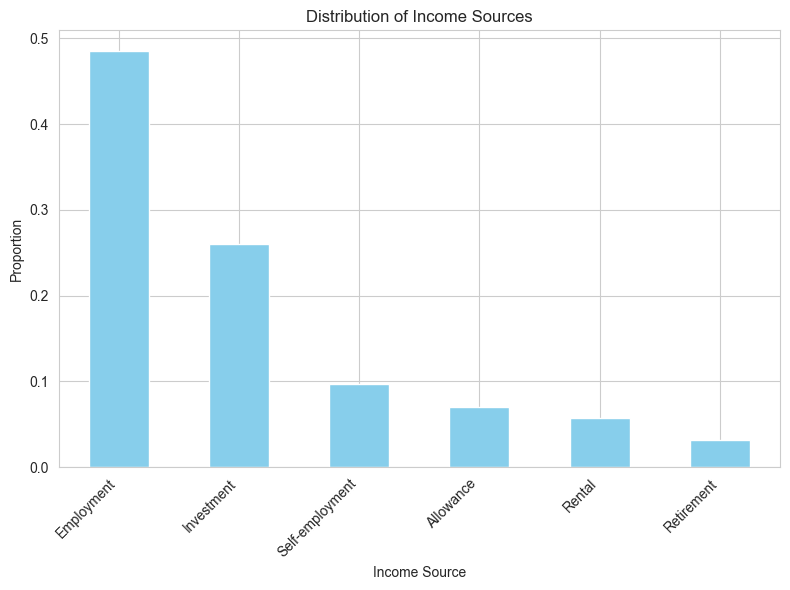

In [205]:
income_distribution = bank_df_train['IncomeSource'].value_counts(normalize=True)

plt.figure(figsize=(8, 6))
income_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Income Sources')
plt.xlabel('Income Source')
plt.ylabel('Proportion')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

#### Retention Rate 

Records success or failure of previous retention efforts, guiding future strategies. % 0-1. Using a beta distribution to model this.

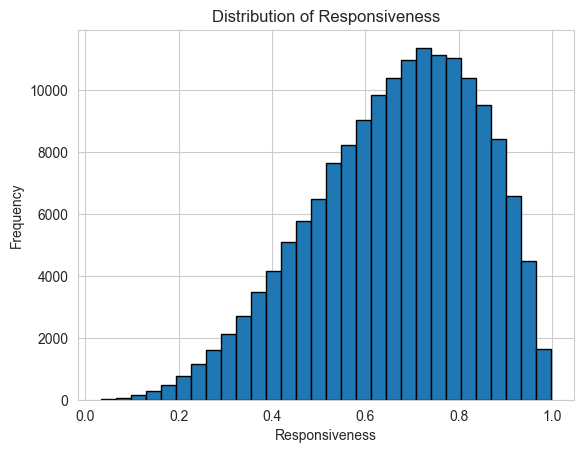

In [206]:
responsiveness_values = np.random.beta(4, 2, size=n_train)

bank_df_train['Retention'] = responsiveness_values

plt.hist(bank_df_train['Retention'], bins=30, edgecolor='black')
plt.xlabel('Responsiveness')
plt.ylabel('Frequency')
plt.title('Distribution of Responsiveness')
plt.show()

#### Mkting Behavioural Changes 
Was there a change in customer behaviour after mkting efforts?
range from 0 to infinity (1 means no change )

In [207]:
bank_df_train['ChangeInBehaviourMkt'] = np.random.normal(1, 0.25, len(bank_df_train))
bank_df_train['ChangeInBehaviourMkt'] = np.maximum(bank_df_train['ChangeInBehaviourMkt'], 0)

print(bank_df_train['ChangeInBehaviourMkt'].describe())

count   165034.000000
mean         0.999792
std          0.249970
min          0.000000
25%          0.830962
50%          1.000832
75%          1.168559
max          2.173273
Name: ChangeInBehaviourMkt, dtype: float64


#### Support Behavioural Change 
Same explanation as above 

In [208]:
bank_df_train['ChangeInBehaviourCust'] = np.random.normal(1, 0.25, len(bank_df_train))
bank_df_train['ChangeInBehaviourCust'] = np.maximum(bank_df_train['ChangeInBehaviourCust'], 0)

print(bank_df_train['ChangeInBehaviourCust'].describe())

count   165034.000000
mean         0.999291
std          0.250165
min          0.000000
25%          0.830514
50%          0.999597
75%          1.168013
max          2.290541
Name: ChangeInBehaviourCust, dtype: float64


#### Previous Lifecycle  

In [209]:
life_cycles = ['Active', 'Dormant', 'Reactivated'] #everything but churned



bank_df_train['PrevLifecycle'] = bank_df_train.apply(
    lambda row: 'Churned' if row['ChurnDate'] <= pd.Timestamp.now() - pd.Timedelta(days=29) else 'Dormant' if row['MonthsInactive'] > 1 else np.random.choice(life_cycles) if row['Tenure'] > 1 else np.nan,
    axis=1
)

print(bank_df_train[['ChurnDate', 'Tenure', 'PrevLifecycle']].describe())
print(bank_df_train['PrevLifecycle'].value_counts())

                           ChurnDate        Tenure
count                          34921 165034.000000
mean   2023-11-05 08:19:29.451046400      9.123199
min              2022-09-02 00:00:00      0.000000
25%              2023-08-15 00:00:00      5.000000
50%              2023-12-07 00:00:00      9.000000
75%              2024-02-20 00:00:00     13.000000
max              2024-04-15 00:00:00     19.000000
std                              NaN      5.161177
PrevLifecycle
Dormant        53945
Active         35444
Reactivated    35119
Churned        30084
Name: count, dtype: int64


#### Current Lifecycle 

In [210]:
prev_active = ['Active', 'Dormant'] #excluding churn, also same for reactivated
prev_dormant = ['Dormant', 'Reactivated'] #excluding churn

bank_df_train['CurrLifecycle'] = bank_df_train.apply(lambda row: 'Churned' if not pd.isnull(row['ChurnDate']) else \
                                                     'Reactivated' if (row['PrevLifecycle'] == 'Dormant' and row['TransactionFreq'] > 0) else \
                                                     'Dormant' if row['TransactionFreq'] == 0 else \
                                                     'Active', axis=1)

print(bank_df_train[['PrevLifecycle', 'CurrLifecycle']].value_counts())

PrevLifecycle  CurrLifecycle
Churned        Churned          30084
Dormant        Dormant          27268
Active         Active           25395
Reactivated    Active           25251
Dormant        Reactivated      25134
Active         Dormant           8481
Reactivated    Dormant           8311
Active         Churned           1568
Reactivated    Churned           1557
Dormant        Churned           1543
Name: count, dtype: int64


#### Happiness 
Based on Num_pdts (0-4) & Brand Satisfaction (0-5)

Binary value of (0,1), 1 is happy 

In [211]:
bank_df_train[['BrandSatisfaction','NumOfProducts']].value_counts()

BrandSatisfaction  NumOfProducts
3                  2                17299
4                  2                17033
5                  2                16887
2                  2                16799
1                  2                16075
2                  1                15805
3                  1                15634
5                  1                15462
4                  1                15453
1                  1                14827
3                  3                  608
1                  3                  581
2                  3                  578
4                  3                  567
5                  3                  555
0                  2                  198
                   1                  193
2                  4                  109
1                  4                  103
3                  4                   98
5                  4                   92
4                  4                   73
0                  3                    5
N

In [212]:
bank_df_train['Happiness'] = 0

condition = (bank_df_train['NumOfProducts'] >= 2) & (bank_df_train['BrandSatisfaction'] >= 2)
bank_df_train.loc[condition, 'Happiness'] = 1

bank_df_train['Happiness'].value_counts()

Happiness
0    94336
1    70698
Name: count, dtype: int64

In [213]:
bank_df_train[bank_df_train['Happiness']==1].shape[0]/n_train*100

42.83844541124859

#### Social Influencer 

Based on NPS value >= 8

1 means Influncer 

In [214]:
bank_df_train['SocialInfluencer'] = 0
influncers = (bank_df_train['NPS'] >= 8)
bank_df_train.loc[influncers, 'SocialInfluencer'] =1

bank_df_train['SocialInfluencer'].value_counts()

SocialInfluencer
0    102872
1     62162
Name: count, dtype: int64

#### Price Sensitivity (Saving Savant)

Mkting offers accepted (ranging 0 to 1)

Mkting Behavioural change (around 0 to 2)

In [215]:
bank_df_train['Savings Savant'] = ((bank_df_train['MarketingOffersAcceptance'].rank(pct=True)*100).astype(int)+(bank_df_train['ChangeInBehaviourMkt'].rank(pct=True)*100).astype(int))/2

#### Feature Driven (Digital Dynamo)

Feature Satisfaction (0 to 5)

Feature Support Freq (0 to 50..?)

In [216]:
bank_df_train['Digital Dynamos'] = ((bank_df_train['FeatureSatisfaction'].rank(pct=True)*100).astype(int)+(bank_df_train['FeatureSupportFrequency'].rank(pct=True)*100).astype(int))/2

#### Service Dependent (Trustee Tribe)

Service Support Freq 

Support Behavioural Change 

Support Satisfaction 

In [217]:
bank_df_train['Trustee Tribe'] = ((bank_df_train['ServiceSupportFrequency'].rank(pct=True)*100).astype(int)+(bank_df_train['SupportSatisfaction'].rank(pct=True)*100).astype(int)+(bank_df_train['ChangeInBehaviourCust'].rank(pct=True)*100).astype(int))/3

#### Normalising the persona quartile 

In [218]:
total = bank_df_train[['Savings Savant', 'Digital Dynamos', 'Trustee Tribe']].sum(axis=1)  
bank_df_train['N_Savings Savant'] = 100 * bank_df_train['Savings Savant'] / total  
bank_df_train['N_Digital Dynamos'] = 100 * bank_df_train['Digital Dynamos'] / total  
bank_df_train['N_Trustee Tribe'] = 100 * bank_df_train['Trustee Tribe'] / total 


#### Persona Allocation 

Current quartile benchmark is 10

In [219]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Restore default warning behavior after your code
# warnings.simplefilter(action='default', category=FutureWarning)

persona_df = bank_df_train[['Savings Savant', 'Digital Dynamos', 'Trustee Tribe']]
largest_values = persona_df.max(axis=1)
smallest_values = persona_df.min(axis=1)

sum_values = persona_df.sum(axis=1)
second_largest_values = sum_values - largest_values - smallest_values
first_diff = largest_values - second_largest_values
second_diff = largest_values - smallest_values

def get_columns(row):
    sorted_indices = np.argsort(row)[::-1]  
    largest_index = sorted_indices[0]  
    second_largest_index = sorted_indices[1] 
    smallest_index = sorted_indices[-1] 
    return (persona_df.columns[largest_index], persona_df.columns[second_largest_index], persona_df.columns[smallest_index])

columns_tuple = persona_df.apply(get_columns, axis=1)
bank_df_train[['FirstPersona', 'SecondPersona', 'ThirdPersona']] = pd.DataFrame(columns_tuple.tolist(), index=persona_df.index)
bank_df_train.loc[first_diff > 10, ['SecondPersona', 'ThirdPersona']] = np.nan
bank_df_train.loc[second_diff > 10, ['ThirdPersona']] = np.nan

print(bank_df_train[['FirstPersona', 'SecondPersona', 'ThirdPersona']].head(10))

      FirstPersona    SecondPersona     ThirdPersona
0    Trustee Tribe              NaN              NaN
1  Digital Dynamos    Trustee Tribe              NaN
2   Savings Savant    Trustee Tribe  Digital Dynamos
3  Digital Dynamos              NaN              NaN
4    Trustee Tribe              NaN              NaN
5   Savings Savant  Digital Dynamos              NaN
6  Digital Dynamos              NaN              NaN
7  Digital Dynamos              NaN              NaN
8  Digital Dynamos              NaN              NaN
9  Digital Dynamos              NaN              NaN


#### Personas Combined 

In [220]:
def combine_personas(row):
    if ('Savings Savant' in row.values) and ('Digital Dynamos' in row.values) and ('Trustee Tribe' in row.values):
        return 'Triple Advantage Allies'
    elif ('Savings Savant' in row.values) and ('Digital Dynamos' in row.values):
        return 'Frugal Innovators'
    elif ('Savings Savant' in row.values) and ('Trustee Tribe' in row.values):
        return 'Cost-Conscious Careseekers'
    elif ('Digital Dynamos' in row.values) and ('Trustee Tribe' in row.values):
        return 'Premium Patrons'
    elif 'Savings Savant' in row.values:
        return 'Savings Savant'
    elif 'Digital Dynamos' in row.values:
        return 'Digital Dynamos'
    elif 'Trustee Tribe' in row.values:
        return 'Trustee Tribe'
bank_df_train['CombinedPersonas'] = bank_df_train[['FirstPersona', 'SecondPersona', 'ThirdPersona']].apply(combine_personas, axis=1)
print(bank_df_train['CombinedPersonas'].head(10))

0              Trustee Tribe
1            Premium Patrons
2    Triple Advantage Allies
3            Digital Dynamos
4              Trustee Tribe
5          Frugal Innovators
6            Digital Dynamos
7            Digital Dynamos
8            Digital Dynamos
9            Digital Dynamos
Name: CombinedPersonas, dtype: object


### Touch Up 

#### Drop irrelevant columns

In [222]:
useless_cols = ['IsActiveMember']
bank_df_train.drop(columns=useless_cols, inplace=True)


#### Datatypes 

In [223]:
print(bank_df_train.dtypes)

Gender                               object
Age                                   int32
Tenure                                int32
Balance                             float64
NumOfProducts                         int64
EstimatedSalary                     float64
Exited                                int64
CustomerId                            int32
ChurnDate                    datetime64[ns]
MonthsInactive                      float64
TransactionFreq                       int32
TransactionAmt                      float64
ServiceSupportFrequency               int32
NPS                                 float64
Education                            object
EmploymentStatus                     object
MaritalStatus                        object
HousingStatus                        object
Dependants                            int32
MarketingOffersAcceptance           float64
PaymentMethod                        object
BrandSatisfaction                     int32
FeatureSatisfaction             

#### One Hot Encoding Current & Previous Lifecycle 

In [224]:
one_hot_encode_prev = pd.get_dummies(bank_df_train, columns=['PrevLifecycle'],dtype ='int').iloc[:,-4:]
one_hot_encode_curr = pd.get_dummies(bank_df_train, columns=['CurrLifecycle'],dtype ='int').iloc[:,-4:]
bank_df_train = pd.concat([bank_df_train, one_hot_encode_prev, one_hot_encode_curr], axis = 1)

### Export as csv 

In [ ]:
train_df, test_df = train_test_split(bank_df_train, test_size=0.2, random_state=42, stratify=bank_df_train['CurrLifecycle'])

print("Train set size:", len(train_df))
print("Test set size:", len(test_df))

train_df.to_csv('./data/final/train.csv', index=False)
test_df.to_csv('./data/final/test.csv', index=False)